In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

In [ ]:
df = pd.read_csv('heart.csv')

In [ ]:
df.columns = df.columns.str.strip() # Removes hidden spaces
# --------------------------------------------------

# Identify the target column dynamically (in case it is 'HeartDisease' or 'target')
target_col = 'HeartDisease' if 'HeartDisease' in df.columns else 'target'

if target_col not in df.columns:
    # If the above fails, let's just take the last column as the target
    target_col = df.columns[-1]
    print(f"Warning: Specific target name not found. Using '{target_col}' as target.")

In [ ]:
X = df.drop(target_col, axis=1)
y = df[target_col]

In [ ]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Features used for training: {X.columns.tolist()}")

Features used for training: ['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ])

In [ ]:
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

In [ ]:
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'sex',
                                                                          'chest '
                                                                          'pain '
                                                                          'type',
                                                                          'resting '
                                                                          'bp '
                                                                          's',
                                                                          'cholesterol',
                                                                          'fasting '
                                                                          'blood '
                                                                          'sugar',
                                                                          'resting '
                                                                          'ecg',
                                                                          'max '
                                                                          'heart '
                                                                          'rate',
                                                                          'exercise '
                                                                          'angina',
                                                                          'oldpeak',
                                                                          'ST '
                                                                          'slope']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         [])])),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__metric': ['euclidean', 'manhattan'],
                         'classifier__n_neighbors': [3, 5, 7, 9, 11, 15],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("-" * 30)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("-" * 30)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

------------------------------
Best Parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}
Final Test Accuracy: 94.12%
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       107
           1       0.93      0.96      0.95       131

    accuracy                           0.94       238
   macro avg       0.94      0.94      0.94       238
weighted avg       0.94      0.94      0.94       238

Confusion Matrix:
[[ 98   9]
 [  5 126]]


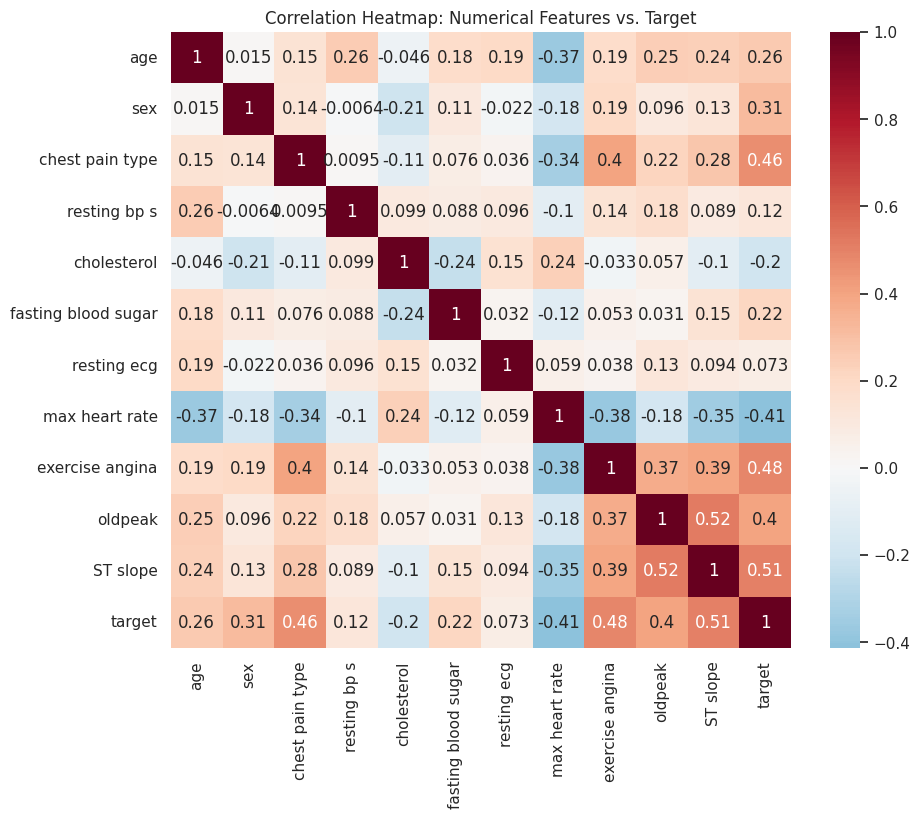

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_features + [target_col]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title("Correlation Heatmap: Numerical Features vs. Target")
plt.show()

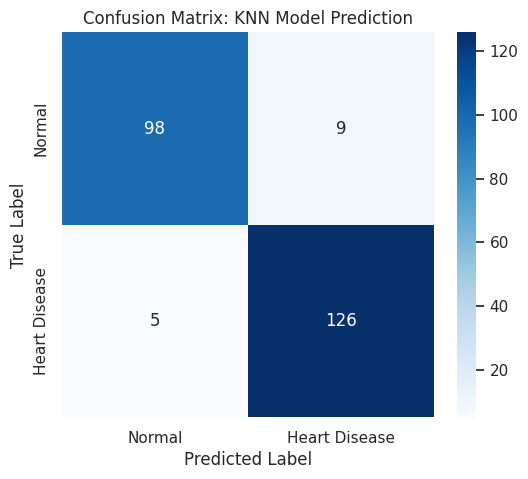

In [ ]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Heart Disease'],
            yticklabels=['Normal', 'Heart Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: KNN Model Prediction')
plt.show()

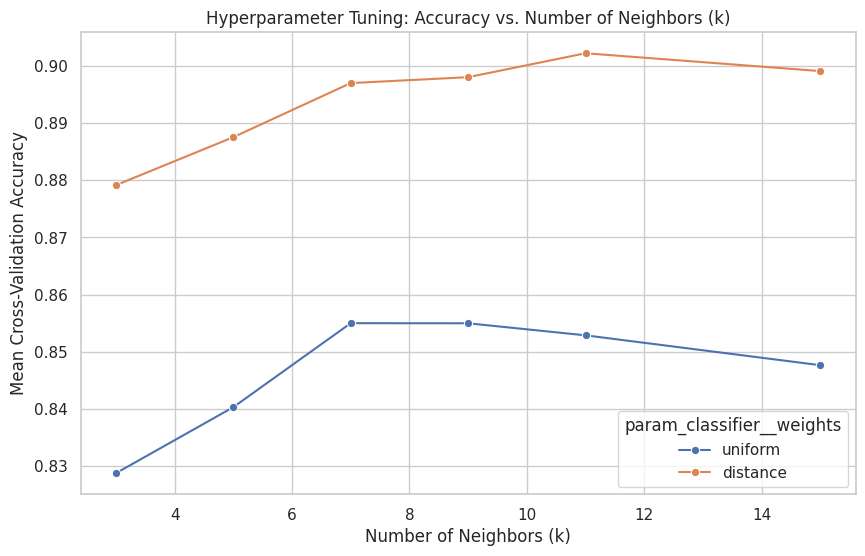

In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)
subset = results_df[results_df['param_classifier__metric'] == 'euclidean']

plt.figure(figsize=(10, 6))
sns.lineplot(data=subset, x='param_classifier__n_neighbors', y='mean_test_score', hue='param_classifier__weights', marker='o')
plt.title('Hyperparameter Tuning: Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.show()

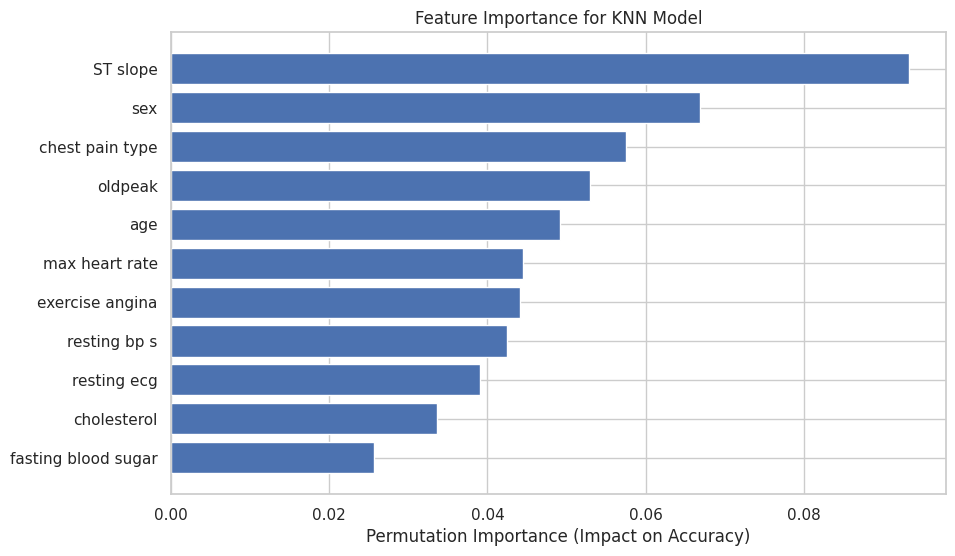

In [ ]:
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Impact on Accuracy)")
plt.title("Feature Importance for KNN Model")
plt.show()